In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
import random
import torch
import pdb

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Architecture du modèle (Basé sur UNet)
En blanc le modèle de base, <span style="color: yellow;">en jaune nos améliorations non terminées,</span> <span style="color: lightgreen;">en vert les améliorations terminées</span>

L’architecture baseline suit la structure classique d’un UNet : *Encoder --> Bottleneck --> Decoder* avec des skip connection skip connections entre blocs symétriques.

### Chemin contractant : Encoder

- On prend en entrée une image à 1 canal et on compresse progressivement les features via 4 blocs encoder :
    - `enc1` : 1 --> 4 canaux
    - `enc2` : 4 --> 8 canaux
    - `enc3` : 8 --> 16 canaux
    - `enc4` : 16 --> 32 canaux (avec dropout pour la régularisation)

- Chaque bloc encoder effectue :
    - une convolution 3×3
    - une normalisation BatchNorm
    - un ReLU
    - <span style="color: yellow;">un dropout optionnel (ajout pour régularisation)</span>
    - un MaxPool pour réduire la résolution spatiale

Ces blocs permettent de capturer progressivement des caractéristiques de plus en plus complexes tout en compressant l’information.

### Bottleneck : Couche centrale

- On arrive au bottleneck (`center`) 32 --> 64 --> 32.

C’est la zone où l’image est représentée de manière la plus compacte avant la reconstruction.

### Bottleneck : Chemin expansif : Decoder

- L’image est ensuite reconstruite via 4 blocs decoder :
    - `dec4` : 64 --> 32 --> 16
    - `dec3` : 32 -6> 16 --> 8
    - `dec2` : 16 --> 8 --> 4
    - `dec1` : 2 convolutions 3*3 (4 --> 4 --> 4) 
 
- Chaque bloc decoder effectue : 
    - une convolution 3×3
    - une normalisation BatchNorm
    - un ReLU
    - un upsampling avec ConvTranspose2d



### Skip Connections

Les sorties des blocs encoder sont concaténées aux blocs decoder correspondants. 
- pour réinjecter des détails locaux provenant de l’encoder, ce qui limite la perte d'information due au bottleneck

### Couche finale

La couche `final` est une convolution 1×1 qui produit C logits pour les C classes --> on obtient un tenseur au format [B, C, H, W]

- B	Taille du batch
- C	Nombre de classes 
- H	Hauteur de l’image
- W	Largeur 

Pour **B** images, pour i allant de 0 à B --> la sortie pour [image i] contient **C** matrices (= une matrice par classe) de dimension **H*W**, avec un logit (=output avant le softmax) pour chaque pixel.

In [3]:
def dice_score(pred, target, num_classes, eps=1e-7):
    """
    Calcule le Dice score pour chaque classe

    Parameters
    ----------
    pred : voir le markdown plus haut
    target : format [B, H, W]
        contient une seule valeur (et une seule matrice) par pixel :
        (0=classe 0, 1=classe 1, 2=classe 2, 3=classe 3)
    num_classes : int
        nombre de classes - incluant le background
    eps : float
        petite valeur pour éviter la division par zéro

    Returns
    -------
    dice_per_class : tensor
        tensor contenant le dice score pour chaque classe (dim [num_classes])
    """
    pred_classes = torch.argmax(pred, dim=1)  # retourne une pred par pixel au format [B, H, W]

    dice_per_class = []
    # on itere sur toutes les classes pour
    for c in range(num_classes):
        # création de masques binaires pour la classe c pour pred et target
        pred_c = (pred_classes == c).float()
        target_c = (target == c).float() 

        intersection = (pred_c * target_c).sum() # ne donne 1 que si la prédition et  la target correspondent
        union = pred_c.sum() + target_c.sum() # la somme des pixels prédits + la somme des pixels réels

        dice = (2 * intersection + eps) / (union + eps)
        dice_per_class.append(dice)

    # retoune un tensor de dimension [num_classes]
    return torch.stack(dice_per_class)

In [4]:
def validate(model, loader, criterion, num_classes, visualise=True, n_examples=1, show_confusion=True):
    """
    Evalue les performances du modèle sur un ensemble de validation (dice + loss)

    Parameters
    ----------
    model : torch.nn.Module
        Le modèle à évaluer
    loader : torch.utils.data.DataLoader
        Dataloader avec les images + labels pour la validation
    criterion : callable
        Fonction de perte utilisée pour calculer le loss 
    num_classes : int
        Nombre de classes de segmentation pour le dice

    Returns
    -------
    avg_loss : float
        Loss moyen sur l’ensemble du dataset
    dice_mean : numpy.ndarray
        Tableau de dim [num_classes] contenant la moyenne du dice 
    pour chaque classe de segmentation

    """
    model.eval()
    total_loss = 0.0
    dice_total = []
    
    # Pour la matrice de confusion
    all_preds = []
    all_gts = []

    import matplotlib.patches as mpatches
    cmap = "jet"
    class_colors = plt.cm.get_cmap(cmap, num_classes)
    legend_patches = [
        mpatches.Patch(color=class_colors(i), label=f"Classe {i}")
        for i in range(num_classes)
    ]

    example_count = 0

    with torch.no_grad():

        for images, labels, _ in loader:

            images = to_var(images)
            labels = to_var(labels)

            outputs = model(images)
            segmentation_classes = getTargetSegmentation(labels)

            # Loss
            loss = criterion(outputs, segmentation_classes)
            total_loss += loss.item()

            # Dice
            dice = dice_score(outputs, segmentation_classes, num_classes)
            dice_total.append(dice.cpu().numpy())

            # ====== MATRICE DE CONFUSION (ACCUMULATION) ====== #
            preds = torch.argmax(outputs, dim=1)     # [B, H, W]
            all_preds.append(preds.cpu().numpy().reshape(-1))
            all_gts.append(segmentation_classes.cpu().numpy().reshape(-1))
            # ================================================== #

            # ====== VISUALISATION (multi exemples) ====== #
            if visualise and example_count < n_examples:
                batch_size = images.size(0)
                to_show = min(batch_size, n_examples - example_count)

                for idx in range(to_show):
                    example_count += 1

                    img_np = images[idx][0].cpu().numpy()
                    gt_np = segmentation_classes[idx].cpu().numpy()
                    pred_np = preds[idx].cpu().numpy()

                    plt.figure(figsize=(16,4))

                    plt.subplot(1,4,1)
                    plt.imshow(img_np, cmap="gray")
                    plt.title("Image")
                    plt.axis("off")

                    plt.subplot(1,4,2)
                    plt.imshow(gt_np, cmap=cmap, vmin=0, vmax=num_classes-1)
                    plt.title("Mask GT")
                    plt.axis("off")

                    plt.subplot(1,4,3)
                    plt.imshow(pred_np, cmap=cmap, vmin=0, vmax=num_classes-1)
                    plt.title("Prédiction")
                    plt.axis("off")

                    plt.subplot(1,4,4)
                    plt.imshow(img_np, cmap="gray")
                    plt.imshow(pred_np, cmap=cmap, alpha=0.45, vmin=0, vmax=num_classes-1)
                    plt.title("Overlay")
                    plt.axis("off")

                    plt.figlegend(handles=legend_patches,
                                  loc="lower center",
                                  ncol=num_classes,
                                  bbox_to_anchor=(0.5, -0.15))
                    plt.tight_layout()
                    plt.show()

            # =============================================== #


    # ==========================
    #   MATRICE DE CONFUSION
    # ==========================
    if show_confusion:

        preds_flat = np.concatenate(all_preds)      # shape [N_pixels]
        gts_flat   = np.concatenate(all_gts)

        cm = confusion_matrix(gts_flat, preds_flat, labels=np.arange(num_classes))

        plt.figure(figsize=(7,6))
        sns.heatmap(cm,
                    annot=True,
                    fmt="d",
                    cmap="Blues",
                    xticklabels=[f"Pred {i}" for i in range(num_classes)],
                    yticklabels=[f"True {i}" for i in range(num_classes)])
        plt.title("Matrice de confusion (pixel-wise)")
        plt.xlabel("Classe prédite")
        plt.ylabel("Classe réelle")
        plt.tight_layout()
        plt.show()

    # ==========================

    dice_mean = np.mean(np.array(dice_total), axis=0)
    return total_loss / len(loader), dice_mean

In [8]:
def runTraining():

    print('-' * 40)
    print('~~~~~~~~  Starting the training... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 4
    batch_size_val = 4 
    lr = 0.01    # Learning Rate
    epoch = 5 # Number of epochs
    
    root_dir = './Data/'

    print(' Dataset: {} '.format(root_dir))

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                      root_dir,
                                                      transform=transform,
                                                      mask_transform=mask_transform,
                                                      augment=False,
                                                      equalize=False)

    train_loader_full = DataLoader(train_set_full,
                              batch_size=batch_size,
                              worker_init_fn=np.random.seed(0),
                              num_workers=0,
                              shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,
                            batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)

    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = 'Test_Model'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = UNet(num_classes)

    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()

    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    ### To save statistics ####
    lossTotalTraining = []
    Best_loss_val = 1000
    BestEpoch = 0

    val_loss_list = []
    dice_list = []
    
    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING
    
    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train() # modèle en mode entrainement
        lossEpoch = []
        DSCEpoch = []
        DSCEpoch_w = []
        num_batches = len(train_loader_full)
        
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net(images)

            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            
            # COMPUTE THE LOSS
            CE_loss_value = CE_loss(net_predictions, segmentation_classes) # XXXXXX and YYYYYYY are your inputs for the CE
            lossTotal = CE_loss_value

            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            
            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(lossTotal.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                             prefix="[Training] Epoch: {} ".format(i),
                             length=15,
                             suffix=" Loss: {:.4f}, ".format(lossTotal))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()

        lossTotalTraining.append(lossEpoch)

        # ---- DICE SCORE ---- #
        with torch.no_grad():
            dice = dice_score(net_predictions, segmentation_classes, num_classes)
            DSCEpoch.append(dice.cpu().numpy())


        printProgressBar(num_batches, num_batches,
                             done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))
        
        # VALIDATION PHASE 
        val_loss, val_dice = validate(net, val_loader, CE_loss, num_classes)
        print(f"[Validation] Epoch: {i}, Loss: {val_loss:.4f}, Dice: {val_dice}")

        # pour les courbes looss et dice
        val_loss_list.append(val_loss)
        dice_list.append(val_dice)

        # SAUVEGARDE DU MEILLEUR MODELE SELON LE LOSS DE VALIDATION
        if val_loss < Best_loss_val:
            Best_loss_val = val_loss
            BestEpoch = i

            if not os.path.exists('./models/' + modelName):
                os.makedirs('./models/' + modelName)

            torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            print(f"Best model updated at epoch {i} (val_loss={val_loss:.4f})")

    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    print("----------------------------------------\n")

    return lossTotalTraining, val_loss_list, dice_list # pour tracer les courbes


        # ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        # ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        # if not os.path.exists('./models/' + modelName):
        #         os.makedirs('./models/' + modelName)

        #     torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            
        # np.save(os.path.join(directory, 'Losses.npy'), lossTotalTraining)


À chaque epoch, le modèle passe successivement par :

- une phase d'entraînement (LossG),
- une phase de validation (val_loss),
- une vérification si le modèle est le meilleur jusqu’ici.

Dans cette fonction, nous avons ajouté :
<p style="color:lightgreen">
- Une fonction pour évaluer le modèle à chaque epoch<br>
- Une fonction pour calculer le Dice score
</p>

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
 Dataset: ./Data/ 
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
[Training] Epoch: 0 [DONE]                                 
[Training] Epoch: 0, LossG: 0.8645                                                                           


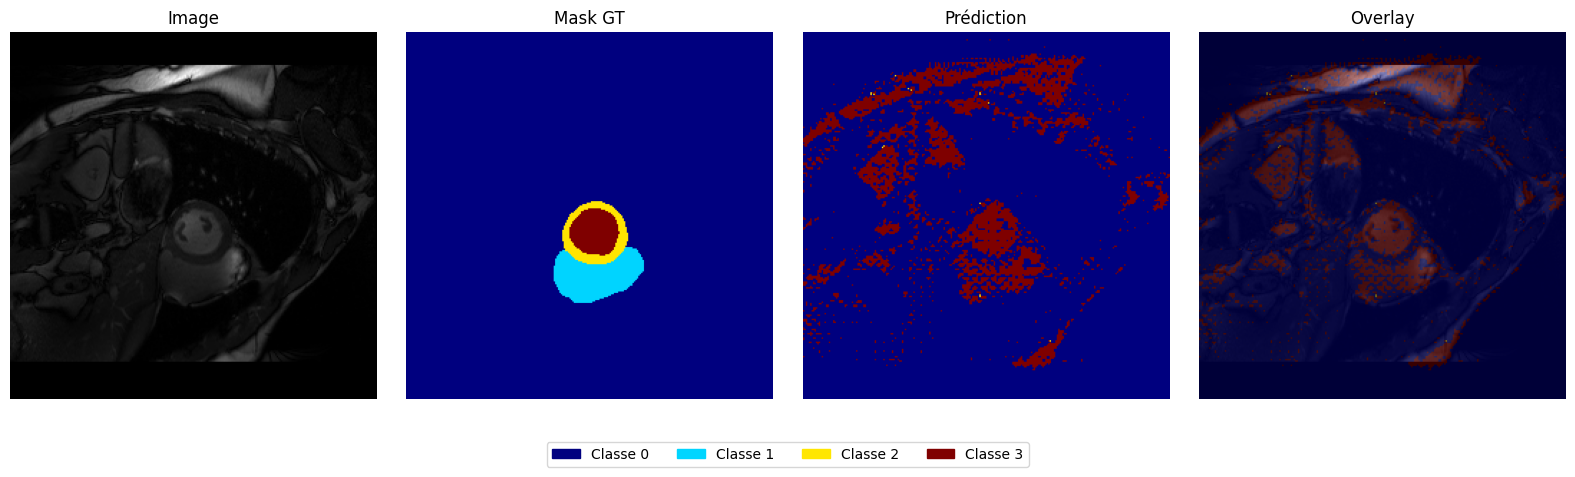

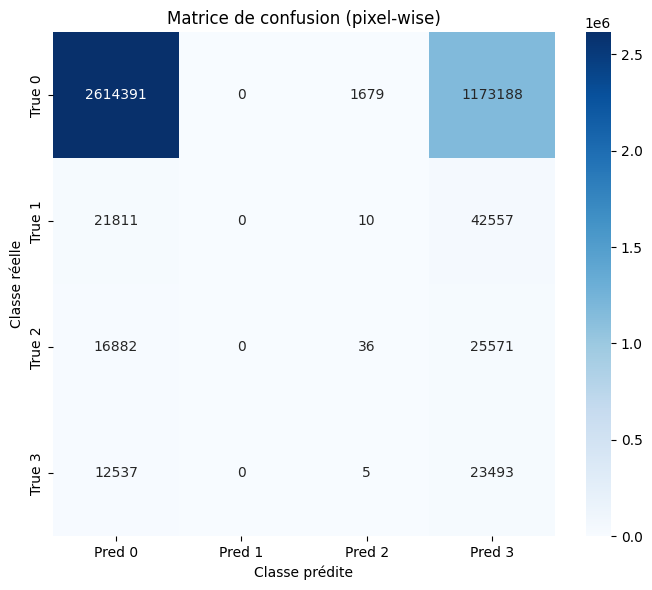

[Validation] Epoch: 0, Loss: 0.8983, Dice: [8.0534047e-01 3.1438931e-11 2.1082594e-03 3.8664777e-02]
Best model updated at epoch 0 (val_loss=0.8983)
[Training] Epoch: 1 [DONE]                                 
[Training] Epoch: 1, LossG: 0.8654                                                                           


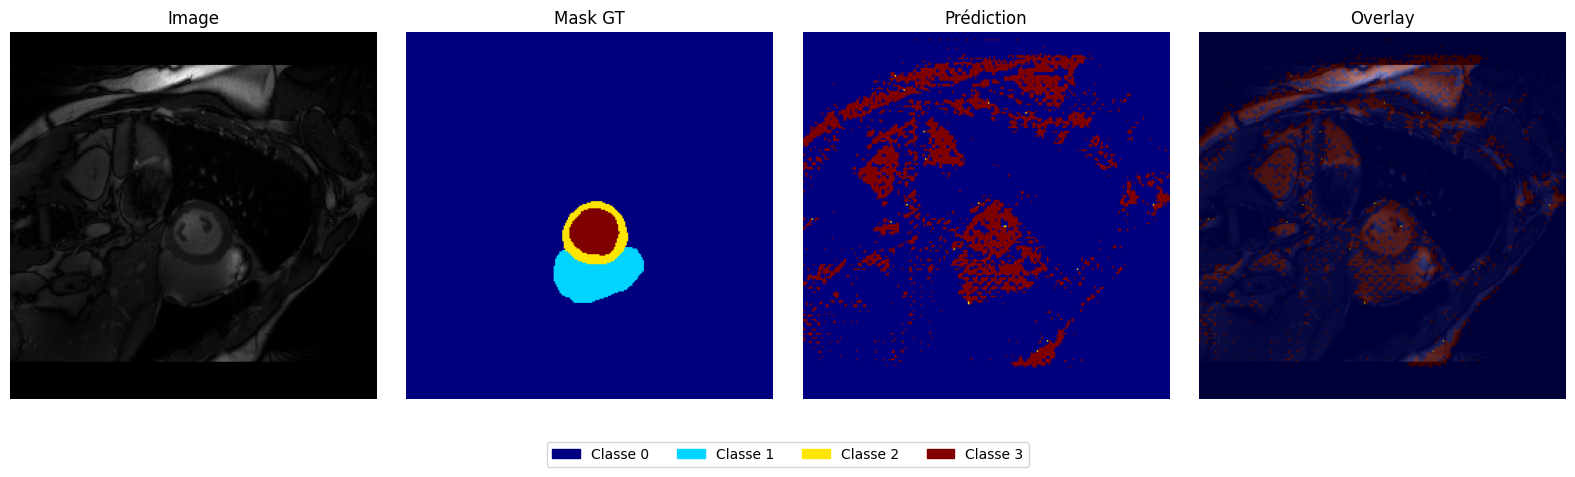

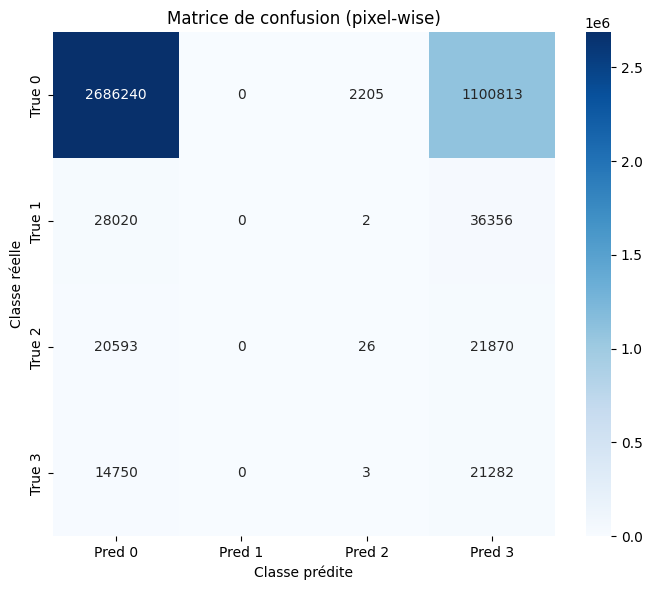

[Validation] Epoch: 1, Loss: 0.8646, Dice: [8.1830901e-01 3.1438931e-11 1.6016953e-03 3.6569253e-02]
Best model updated at epoch 1 (val_loss=0.8646)
[Training] Epoch: 2 [DONE]                                 
[Training] Epoch: 2, LossG: 0.8659                                                                           


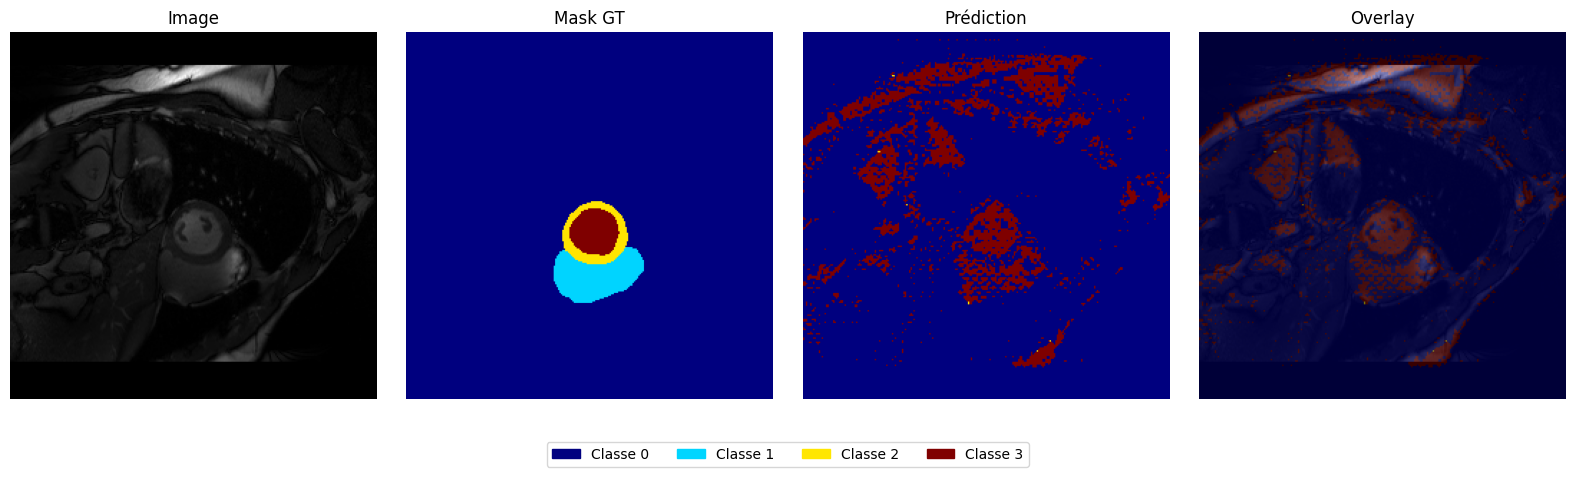

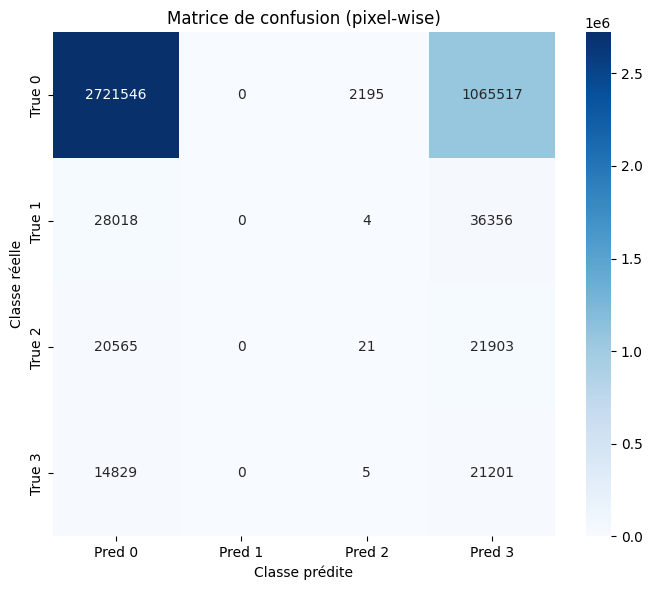

[Validation] Epoch: 2, Loss: 0.8480, Dice: [8.2461840e-01 3.1438931e-11 1.2365013e-03 3.7375055e-02]
Best model updated at epoch 2 (val_loss=0.8480)
[Training] Epoch: 3 [DONE]                                 
[Training] Epoch: 3, LossG: 0.8653                                                                           


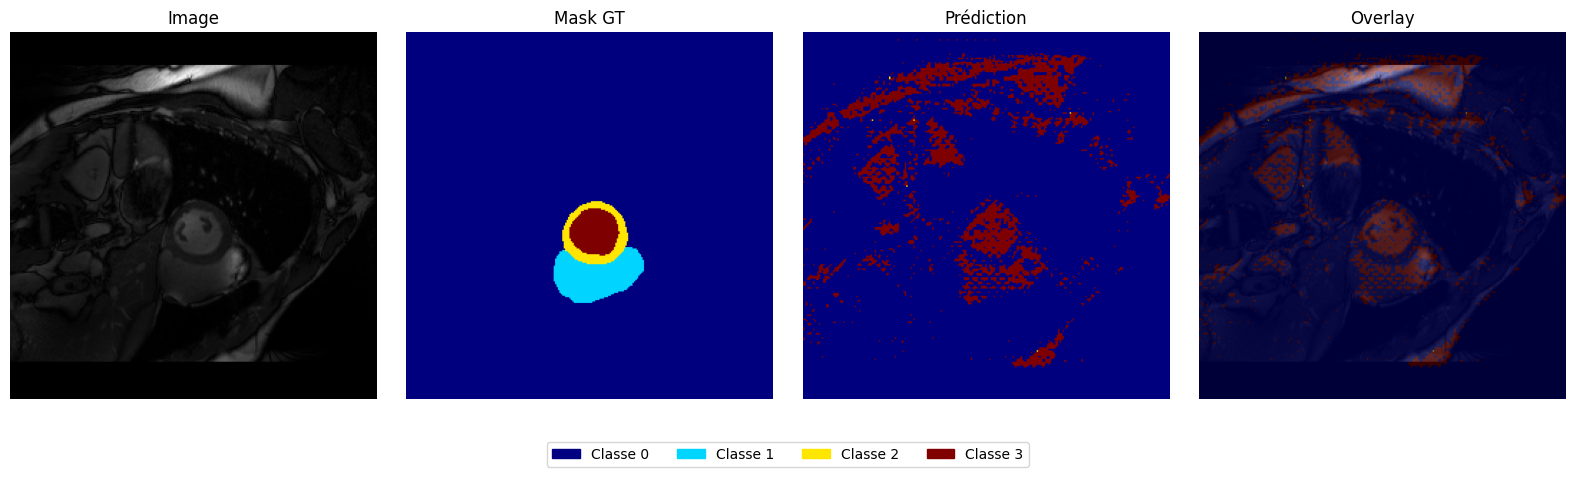

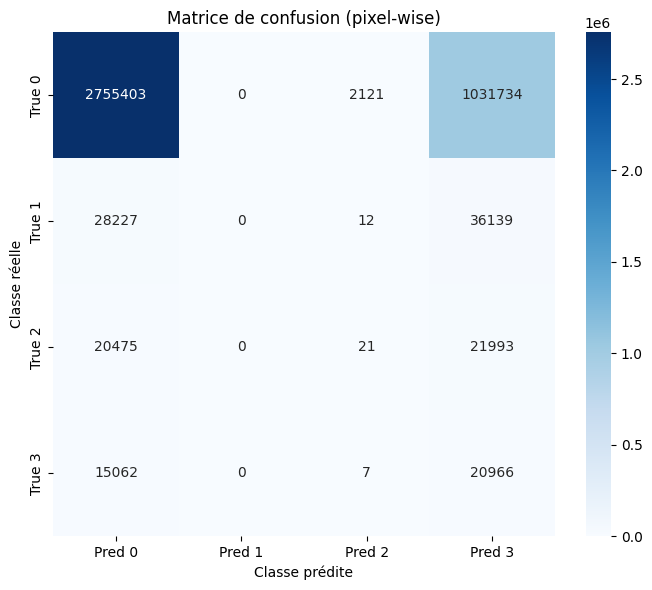

[Validation] Epoch: 3, Loss: 0.8335, Dice: [8.3056355e-01 3.1438931e-11 1.2808164e-03 3.7943315e-02]
Best model updated at epoch 3 (val_loss=0.8335)
[Training] Epoch: 4 [DONE]                                 
[Training] Epoch: 4, LossG: 0.8653                                                                           


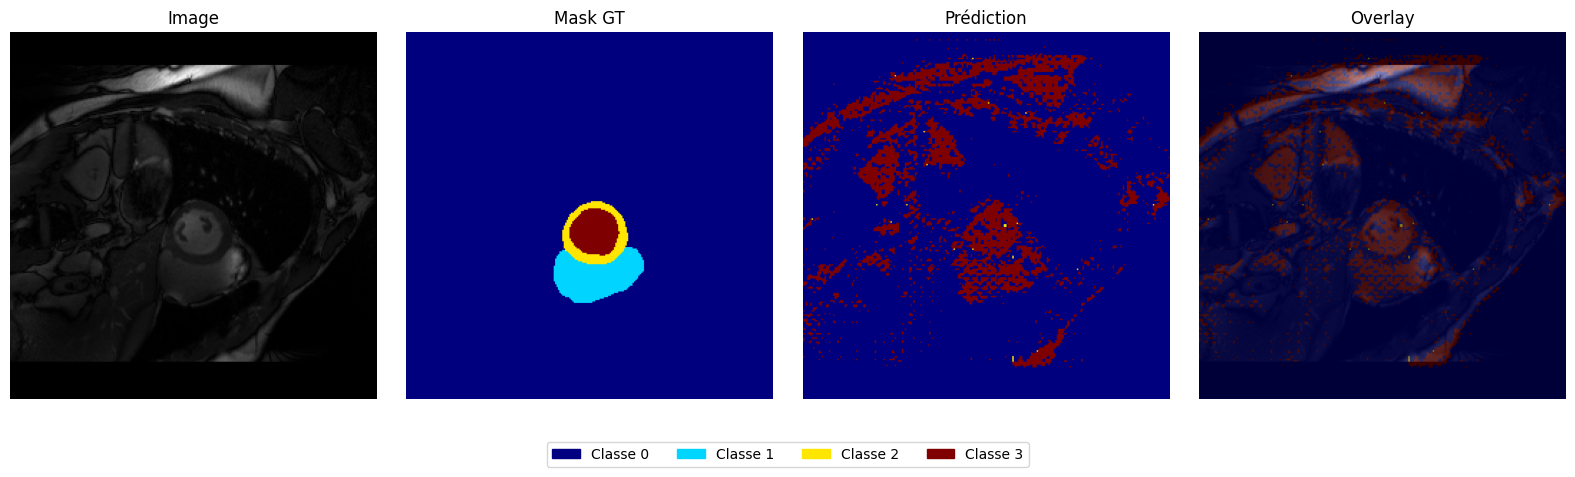

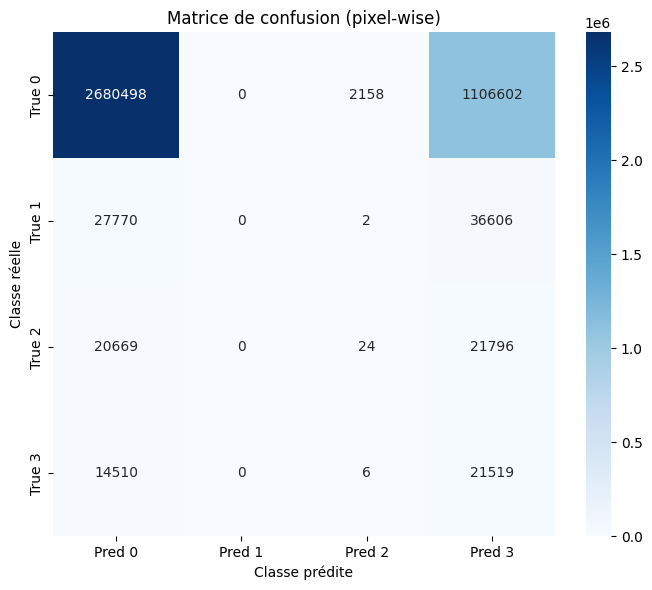

[Validation] Epoch: 4, Loss: 0.8698, Dice: [8.172523e-01 3.143893e-11 1.543443e-03 3.681318e-02]

----------------------------------------
Best model found at epoch 3 with validation loss = 0.8335
----------------------------------------



In [9]:
lossTotalTraining, val_loss_list, dice_list = runTraining()

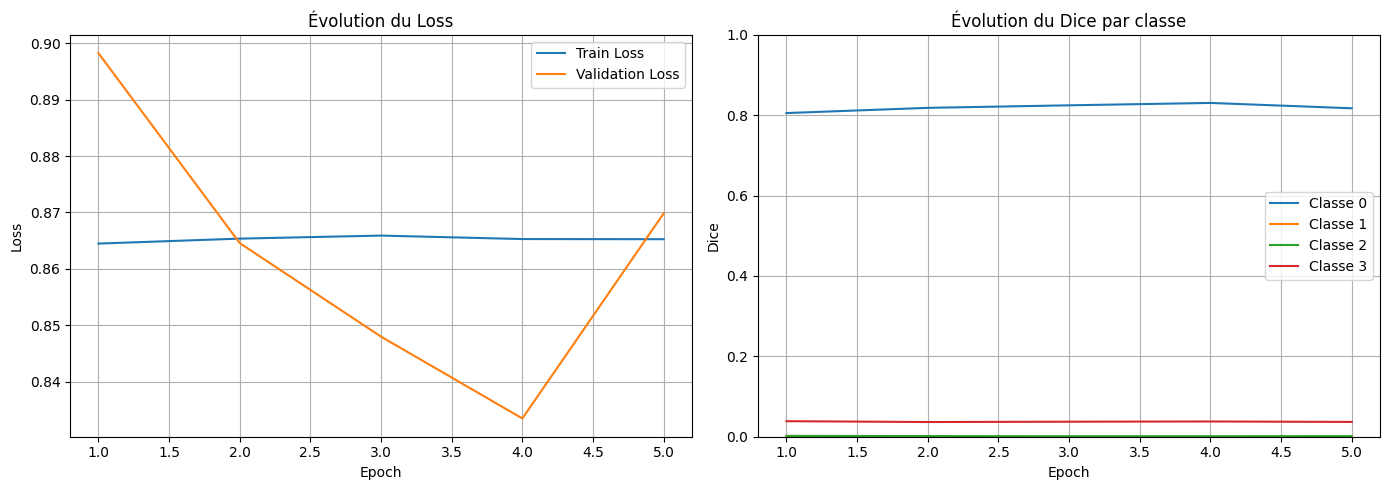

In [10]:

def plot_training_curves(loss_train, loss_val, dice_list):

    epochs = np.arange(1, len(loss_train) + 1)

    plt.figure(figsize=(14,5))

    # ----- TRAIN / VAL LOSS -----
    plt.subplot(1,2,1)
    plt.plot(epochs, loss_train, label="Train Loss")
    plt.plot(epochs, loss_val, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Évolution du Loss")
    plt.legend()
    plt.grid(True)

    # ----- DICE SCORE -----
    plt.subplot(1,2,2)
    
    dice_array = np.array(dice_list)  # shape: [epochs, num_classes]
    num_classes = dice_array.shape[1]

    for c in range(num_classes):
        plt.plot(epochs, dice_array[:, c], label=f"Classe {c}")

    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.title("Évolution du Dice par classe")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(lossTotalTraining, val_loss_list, dice_list)

On observe que la perte d’entraînement reste stable autour de 1.07 pour toutes les époques :
- Cela indique que le modèle baseline apprend très peu, ou pas du tout.
- Le modèle apprend un peu au début (jusqu'à epoch : 6), puis commence à stagner ou légèrement sur-apprendre
- Meilleur modèle = epoch 6

A faire ensuite :
- Améliore le modèle
- faire un dice score
- visualiser les différentes étapes/prédictions

**Selon l'ami le chat :**

🔍 Que vérifier maintenant ?

Parce que ton loss stable est louche, tu devrais vérifier :

✔ 1. getTargetSegmentation(labels)

Est-ce que ça renvoie bien un tenseur [B,H,W] d'entiers (classes) ?

✔ 2. Les labels contiennent plusieurs classes ?

Si tout est 0 → CE ~1.07 est normal.

✔ 3. Le learning rate

lr = 0.01 est assez agressif pour UNet.
Essaie 0.001 ou 0.0001.

✔ 4. Visualiser quelques prédictions

Pour vérifier que les masques prévus ne sont pas tous pareils.